# ReforesTree 🌴

We are excited to share with you the ReforesTree dataset! 🎉
We introduce the ReforesTree dataset in hopes of encouraging the fellow machine learning community to take on
the challenge of developing low-cost, scalable, trustworthy and accurate solutions for monitoring, verification and reporting of tropical reforestation inventory. 

#### This is a dataset for the following 6 agroforestry sites
In alphabetical order
1. _Carlos Vera Arteaga_
2. _Carlos Vera Guevara_
3. _Flora Pluas_
4. _Leonor Aspiazu_
5. _Manuel Macias_
6. _Nestor Macias_


## Dataset Components
For each site the data we publish consists of four components free for use:
1. 🛸 Raw drone RGB images _(see wwf_ecuador/"Name of site")_
2. 🌴 Hand measured tree parameters (diameter at breast height, species, biomass, and location) of every tree _(see field_data.csv)_
3. 🔲 Set of bounding boxes of trees for each site cleaned by hand and labeled as banana or not banana _(see annotations/cleaned)_
4. ↔️ Mappings of these bounding boxes with tree labels based on location _(see mappings/final)_


## Tutorial
In this tutorial we go through the steps to recreate (and hopefully improve) the dataset and how to use it. 

Please read our paper [here](https://arxiv.org/abs/2201.11192).
For any questions, please reach out to gyri.reiersen@tum.de or david.dao@inf.eth.ch

## Load packages and modules

In [ ]:
!pip install -Ur requirements.txt

In [ ]:
pip install exifread slidingwindow deepforest lxml

In [ ]:
pip show deepforest

In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import reshape_as_image
import PIL
from PIL import Image
PIL.Image.MAX_IMAGE_PIXELS = None
import sys
package = os.path.dirname(os.getcwd())
sys.path.append(package)
sys.path.append(package + 'utils')

#import seaborn as sns
#colors = sns.color_palette('tab10')
#mypalette={'NN':colors[0], 'GMN':colors[4], 'OT':colors[1], 'OT on GPS position':colors[1], 'GW':colors[2], 'OT on GPS position + Tree species':colors[3]}
#import matplotlib.pylab as plt
#import tensorflow

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from utils.extract_features import *
from utils.deepforest_detection import *
#from utils.visualisation import *
#from utils.plot_folium import *
#from utils.plot_density import *
#from utils.mapping import *

Data Importing

In [ ]:
pip install torchgeo

In [ ]:
#from torchgeo.datasets import ReforesTree
#ds = ReforesTree(root="data/reforestree/", download=True, checksum=True)

## Data Processing

### 🛸 Split raw drone RGB orthomosaics into image tiles
1. **Extract drone informations on each site:**
Based on the raw data we create the dataframe _ortho_data.csv_ that contains all important information on the drone orthomosaics RGB: minimimal and maximal latititude, longitude, width and height (pixels).


2. **Split the orthomosaics into 400x400 tiles:**
To be able to handle the drone data we need to split the large .tif files into tiles that is stored in _data/tiles_. 

In [ ]:
directory = "data/wwf_ecuador/RGB Orthomosaics"
save_dir = "data/tiles"

# Extracting the main information for each site 
ortho_data = create_ortho_data(directory, os.path.join(save_dir, 'ortho_data.csv'))

In [ ]:
# Split images into tiles (might takes some minutes)
for file in os.listdir(directory):
    if file.endswith('.tif'):
        # Open image file for reading (binary mode)
        path_to_raster = os.path.join(directory, file)
        name = file.replace('.tif', '')

        tiles_dir = os.path.join(save_dir, name)
        if not os.path.exists(tiles_dir):
            os.makedirs(tiles_dir)        
            split_raster(path_to_raster, base_dir=tiles_dir, patch_size=4000, patch_overlap=0.05)

### 🌴 Rescale drone bounds using field data

The "_field_data.csv_" contains all the trees on the sites. Each row includes information on the tree parameters as well as the locations and calculated aboveground biomass (AGB) and carbon. 

PS: It is worth noting that the column "updated diameter" is being used for DBH. For completeness and transparancy, the comlumn "diameter" is kept and for the trees with missing values (especially cacao) an extrapolated diameter was calculated based on avg. diameter for that species for the year the tree was planted. 

A separate tutorial on how the processing of the field data is TBD.

In [ ]:
field_data = pd.read_csv('data/field_data.csv')
field_data

In [ ]:
# Then to the actual rescaling
list_sites = ['Carlos Vera Arteaga RGB', 'Carlos Vera Guevara RGB', 'Flora Pluas RGB', 'Leonor Aspiazu RGB', 
             'Manuel Macias RGB', 'Nestor Macias RGB']

ortho_data = rescale_bounds(ortho_data, field_data, list_sites)
ortho_data.to_csv(os.path.join(save_dir, 'ortho_data.csv'), index = False)

## 🔲 DeepForest Tree Detection

From tiles to bounding box annotations! For that we use a pretrained and finetuned DeepForest model.

Note reg finetuning: To make sure our model was able to detect the trees in these sites accurately, we finetuned it on some hand-created bounding boxes. 

In [ ]:
pip install deepforest

In [ ]:
pip install torch torchvision torchaudio

In [ ]:
# Load model 
#model = deepforest.deepforest(saved_model = os.getcwd()+'/data/model/deepforest/final_model_4000_epochs_35.h5')

In [ ]:
import os
import pandas as pd
import torch

# Detect the device
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal Performance Shaders
    print("Using MPS (Metal Performance Shaders) for processing.")
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("Using CPU for processing.")

# Define column names for annotations
column_names = ['img_path', 'xmin', 'ymin', 'xmax', 'ymax', 'score']

# Set up directories
dir = os.path.join(os.getcwd(), 'data')
tiles_dir = os.path.join(dir, 'tiles')
ann_dir = os.path.join(dir, 'annotations')

if not os.path.exists(ann_dir):
    os.makedirs(ann_dir)

# Process tiles and generate annotations
for folder in os.listdir(tiles_dir):
    if not (folder.startswith('.') or folder.startswith('ortho_data.csv')):  # Skip hidden/system files
        file_path = os.path.join(ann_dir, f"{folder}_annotations.csv")
        if not os.path.exists(file_path):
            annotations_files = pd.DataFrame(columns=column_names)
            folder_path = os.path.join(tiles_dir, folder)

            for file in os.listdir(folder_path):
                if not file.startswith('.'):  # Skip hidden/system files
                    # Ensure the model processes tiles on the correct device
                    tile_annotations = get_annotations(
                        os.path.join(folder_path, file),
                        model.to(device)  # Send model to the selected device
                    )
                    annotations_files = pd.concat([annotations_files, tile_annotations])

            # Reset the index of the concatenated DataFrame
            annotations_files = annotations_files.reset_index(drop=True)

            # Save annotations to CSV
            annotations_files.to_csv(file_path, index=False)
        print(f'DeepForest annotations are saved for site {folder}')

#### Additional tile information per bounding box annotation

For each tree annotation we add tree location, tile position, and site.

In [ ]:
for site_name in list_sites:
    for file in os.listdir(ann_dir):
        if (file == '{}_annotations.csv'.format(site_name)):
            file_path = os.path.join(ann_dir,file)
            df = pd.read_csv(file_path)
            
            if not ('Xmin' in df.columns): # in case you have done this before
                df['img_name'], df['tile_index'], df['tile_xmin'], df['tile_ymin'], df['tile_xmax'], df['tile_ymax'] = zip(*df['img_path'].map(expand_tile_features))
                df[['x', 'y']] = df.apply(lambda x: [get_center(x.xmin,x.xmax), get_center(x.ymin,x.ymax)], axis=1, result_type="expand")

                df['Xmin'] = df.xmin + df.tile_xmin
                df['Ymin'] = df.ymin + df.tile_ymin
                df['Xmax'] = df.xmax + df.tile_xmin
                df['Ymax'] = df.ymax + df.tile_ymin
                df['X'] = df.x + df.tile_xmin
                df['Y'] = df.y + df.tile_ymin

                df[['lon', 'lat']] = df.apply(lambda x: convert_xy_tile_to_lonlat(x.img_name, x.tile_xmin, x.tile_ymin, x.x, x.y, ortho_data), axis=1, result_type="expand")
                df.to_csv(file_path, index = False)
            print('Added info for {}'.format(site_name))
        

In [ ]:
# Merge annotations files of each site into one file
all_annotations = pd.DataFrame()

for file in os.listdir(ann_dir):
    if not (file.startswith('.') or file.startswith('c') or file.startswith('a')):
        file_path = os.path.join(ann_dir, file)
        df = pd.read_csv(file_path)
        all_annotations = pd.concat([all_annotations, df])
all_annotations.to_csv(os.path.join(ann_dir,'all_annotations.csv'))

In [ ]:
clean_annotations = pd.read_csv('data/annotations/cleaned/clean_annotations.csv')
clean_annotations.columns

## Processing Annotations for Kernel Density

In [26]:
import pandas as pd

# Step 1: Read the CSV data
df = pd.read_csv('data/annotations/cleaned/clean_annotations.csv')

# Step 2: Filter the data for the specific image name "Carlos Vera Arteaga RGB"
img_name = "Carlos Vera Arteaga RGB"
img_data = df[df['img_name'] == img_name]

# Step 3: Count the number of trees for this image
tree_count = img_data.shape[0]

# Print the number of trees
print(f'Number of trees for {img_name}: {tree_count}')

Number of trees for Carlos Vera Arteaga RGB: 1122


data/annotations/cleaned/clean_annotations.csv

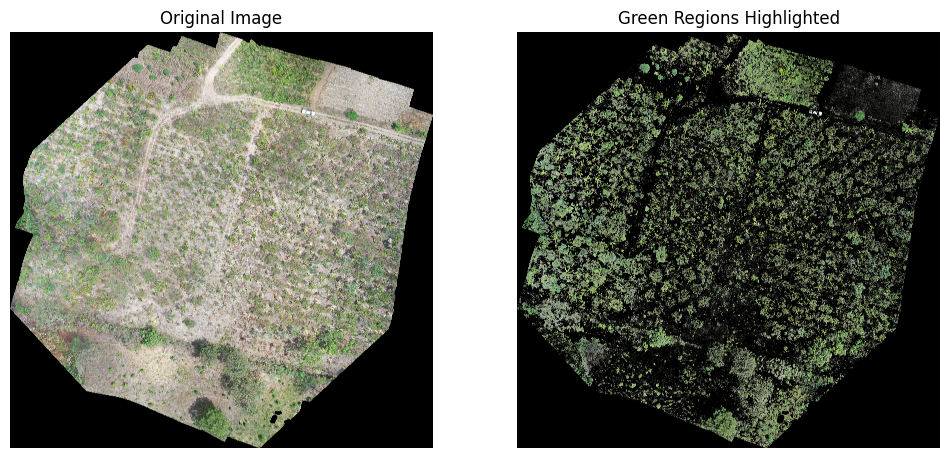

Green Coverage: 23.54%


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def analyze_reforestation(image_path, green_threshold=0.4):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format

    # Normalize pixel values to 0-1
    normalized_image = image / 255.0

    # Extract R, G, B channels
    red_channel = normalized_image[:, :, 0]
    green_channel = normalized_image[:, :, 1]
    blue_channel = normalized_image[:, :, 2]

    # Define "greenest" pixels
    green_mask = (green_channel > green_threshold) & (green_channel > red_channel) & (green_channel > blue_channel)

    # Calculate the percentage of green pixels
    total_pixels = image.shape[0] * image.shape[1]
    green_pixels = np.sum(green_mask)
    green_percentage = (green_pixels / total_pixels) * 100

    # Highlight the greenest regions in the image
    highlighted_image = image.copy()
    highlighted_image[~green_mask] = [0, 0, 0]  # Set non-green pixels to black

    # Display the original and highlighted images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Green Regions Highlighted")
    plt.imshow(highlighted_image)
    plt.axis("off")
    plt.show()

    # Return results
    return green_percentage

image_path = "data/wwf_ecuador/RGB Orthomosaics/Carlos Vera Arteaga RGB.tif"
green_percentage = analyze_reforestation(image_path)
print(f"Green Coverage: {green_percentage:.2f}%")

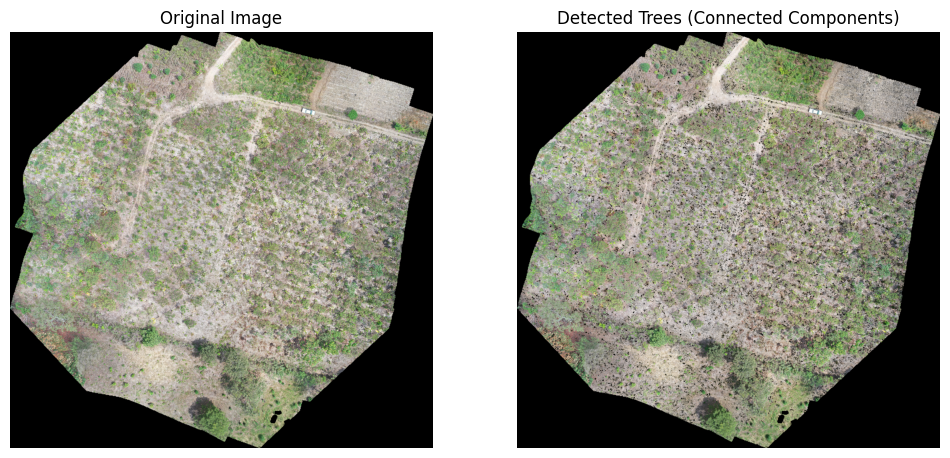

Number of Trees Detected: 1243


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def identify_green_regions_and_detect_trees(image_path, green_threshold=0.4, min_area=100, resize_factor=0.2):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format

    # Resize the image to speed up processing (optional)
    if resize_factor < 1.0:
        image = cv2.resize(image, (0, 0), fx=resize_factor, fy=resize_factor)

    # Normalize pixel values to 0-1
    normalized_image = image / 255.0

    # Extract R, G, B channels
    red_channel = normalized_image[:, :, 0]
    green_channel = normalized_image[:, :, 1]
    blue_channel = normalized_image[:, :, 2]

    # Define "greenest" pixels using numpy vectorized operations
    green_mask = (green_channel > green_threshold) & (green_channel > red_channel) & (green_channel > blue_channel)

    # Find connected components in the green mask
    num_labels, labels = cv2.connectedComponents(green_mask.astype(np.uint8))

    # Filter out small components based on area (to avoid noise)
    sizes = [np.sum(labels == i) for i in range(num_labels)]
    large_components = [i for i, size in enumerate(sizes) if size > min_area]

    # Create a new image with only the large connected components (trees)
    tree_mask = np.isin(labels, large_components)

    # Create the result image
    result_image = image.copy()
    result_image[~tree_mask] = [0, 0, 0]  # Set non-tree pixels to black

    # Show the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Detected Trees (Connected Components)")
    plt.imshow(result_image)
    plt.axis("off")
    plt.show()

    # Return the number of trees detected
    return len(large_components)

# Example Usage
image_path = "data/wwf_ecuador/RGB Orthomosaics/Carlos Vera Arteaga RGB.tif"
tree_count = identify_green_regions_and_detect_trees(image_path, green_threshold=0.4, min_area=100, resize_factor=0.2)
print(f"Number of Trees Detected: {tree_count}")
